**This notebook aims to tackle the ARC Prize 2024 competition by developing AI models capable of solving previously unseen reasoning tasks, using the Abstraction and Reasoning Corpus (ARC). I explore various techniques such as transfer learning, few-shot learning, and symbolic reasoning to enhance the model’s generalization abilities. My goal is to push the boundaries of artificial general intelligence (AGI) and move closer to achieving human-level reasoning performance.**

In [1]:
# Import libraries 
import numpy as np # numerical operations and linear algebra.
import pandas as pd # handling data processing and reading CSV files.
import os # interact with the operating system and work with file paths.
import gc # manage memory and free up unused memory.
import random # generating random numbers, useful in certain tasks such as shuffling data.
import json # handle JSON file reading and parsing, which is often the format for ARC data.
import seaborn as sns #  advanced visualization of data.
from scipy import stats # statistical analysis and distributions.
from pathlib import Path # more convenient handling of file paths.

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt # creating plots and visualizations.

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json


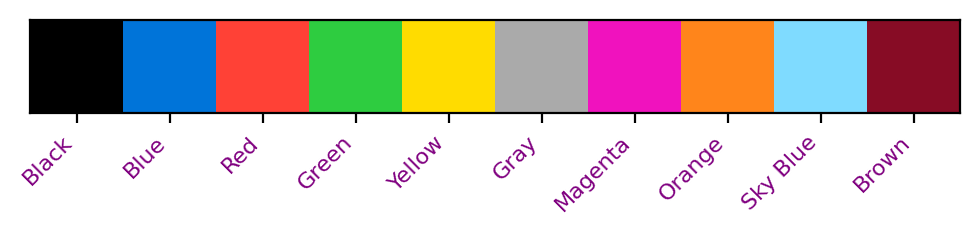

In [2]:
training1_path = '/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
training2_path = '/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json'

evaluation1_path ='/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json'
evaluation2_path = '/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json'

test_path = '/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json'
sample_path = '/kaggle/input/arc-prize-2024/sample_submission.json'

# Import required libraries
from matplotlib import colors
%matplotlib inline

# Create a custom ListedColormap with engaging colors
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

# Normalize the color range to match the number of colors
norm = colors.Normalize(vmin=0, vmax=9)

# Define a more descriptive color list
color_list = ["Black", "Blue", "Red", "Green", "Yellow", "Gray", "Magenta", "Orange", "Sky Blue", "Brown"]

# Plot the color map
plt.figure(figsize=(6, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)

# Add the color labels
plt.xticks(list(range(10)), color_list, rotation=45, ha="right", fontsize=8, color='purple')

# Hide y-axis since it's not needed
plt.yticks([])

# Show the plot
plt.show()


In [3]:
def plot_pic(x):
    """
    Plot a single image using the defined colormap and normalization.

    Parameters:
    x (array-like): Input image data.
    """
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.axis('off')  # Remove axis for cleaner visualization
    plt.show()


In [4]:
def plot_data(task):
    """
    Plot the training and test data with both input and output images.

    Parameters:
    task (dict): Task data containing 'train' and 'test' examples.
    """
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n, 8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0

    # Plot training examples
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_xticks([])  # Clean ticks
        axs[0][fig_num].set_yticks([])

        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_xticks([])
        axs[1][fig_num].set_yticks([])

        fig_num += 1

    # Plot testing examples
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_xticks([])
        axs[0][fig_num].set_yticks([])

        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_xticks([])
        axs[1][fig_num].set_yticks([])

        fig_num += 1

    plt.tight_layout()
    plt.show()


In [5]:
def plot_task(task):
    """
    Plot only the input data for training and test sets.

    Parameters:
    task (dict): Task data containing 'train' and 'test' examples.
    """
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n, 8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0

    # Plot training inputs
    for i, t in enumerate(task["train"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_xticks([])
        axs[0][fig_num].set_yticks([])

        fig_num += 1

    # Plot testing inputs
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_xticks([])
        axs[0][fig_num].set_yticks([])

        fig_num += 1

    plt.tight_layout()
    plt.show()


In [6]:
# Load the challenge (training) files
with open(training1_path, 'r') as f:
    training1_data = json.load(f)

# Load the solutions (training) files
with open(training2_path, 'r') as f:
    training2_data = json.load(f)

# Extract the challenge names from the files (keys)
training1_name = list(training1_data.keys())
training2_name = list(training2_data.keys())

# Check if challenge names match between the two files and get the total number of entries
match_status = (training1_name == training2_name)
total_challenges = len(training2_name)

# Display result
print(f"Do the challenge names match? {match_status}")
print(f"Total number of challenges: {total_challenges}")


Do the challenge names match? True
Total number of challenges: 400


In [7]:
# Load and process JSON files
with open(training1_path, 'r') as f:
    training1_data = json.load(f)
    training1_task = list(training1_data.values())

with open(training2_path, 'r') as f:
    training2_data = json.load(f)
    training2_task = list(training2_data.values())

# Output the lengths
print("Length of training1_task:", len(training1_task))
print("Length of training2_task:", len(training2_task))


Length of training1_task: 400
Length of training2_task: 400


In [8]:

from colorama import Style, Fore

def train_visualize(t):
    # Create DataFrame for train1 task and apply styling
    df_training1 = pd.DataFrame(data={'Task Name': [training1_name[t]], 'Files': ['training_challenges']}, index=[t])
    df_training1_styled = df_training1.style.applymap(
        lambda x: 'background-color: #D5F5E3; color: #1D8348' if x == 'training_challenges' else '', 
        subset=['Files']
    )
    
    # Display styled DataFrame for train1
    display(df_training1_styled)
    plot_task(training1_task[t])
    
    # Create and display DataFrames for train2 tasks with styling
    for i in range(len(training2_task[t])):
        df_training2 = pd.DataFrame(data={'Answers for task': [training2_name[t]], 'Items': [i], 'Files': ['training_solutions']}, index=[t])
        df_training2_styled = df_training2.style.applymap(lambda x: 'background-color: #D4E6F1; color: #2980B9' if x == 'training_solutions' else '', subset=['Files'])
        
        display(df_training2_styled)
        plot_pic(training2_task[t][i])
        
    # Print a decorative separator
    print('\n', ' '*40, f'{Style.BRIGHT}{Fore.CYAN}|§|'*20, '\n')

# Sample function definitions for plot_task and plot_pic
def plot_task(task):
    # Your implementation for plotting a task
    pass

def plot_pic(pic):
    # Your implementation for plotting a picture
    pass
